In [ ]:
# default_exp primitives

# Primitives

> Implementations for vertex, edges, cell(s), and cell monolayer

In [ ]:
#hide
from nbdev.showdoc import *

- `vertex`: stores 2D position of a given vertex 1x2 numpy array. Should implement a method for distance calculation.
- `edges`: (currently) adjacency matrix that represents connectivity of vertices
- `cell` : a subset of vertices that represents a cell. Implements area, and perimeter calculations.
- `monolayer`: stores cells, with their corresponding vertices, edges, and boundary conditions. Also should implement energy calculation together with its spatial gradient.

## Vertex

In [ ]:
#export
import torch
class Vertex(object):
    '''Implements vertex and stores its position as a 1x2 `torch.Tensor`:(x,y).
    
    - Methods:
        > `dist(self,other)`
        
        > `zero_grad_(self)`
        
        > `grad(self)`
    - Properties :
        > `x`
    '''
    def __init__(self,location=None):
        '''access `location` with self.x '''
        self._x=location
    
    def dist(self,other):
        '''Calculate (Euclidean) distance to another vertex'''
        return torch.sqrt(torch.sum(torch.pow(other.x - self._x,2)))
    
    def zero_grad_(self):
        '''set gradients to zero if x.requires_grad==True'''
        if self._x.grad is not None:
            self._x.grad.data.zero_()
    
    def grad(self):
        '''Get accumulated gradients w/ respect to x (calculated with backprop)'''
        if self._x.grad is not None:
            return self._x.grad
    
    @property
    def x(self):
        '''Get current location'''
        return self._x
    @x.setter
    def x(self, val):
        self._x = val
    
    def __str__(self):
        return f"{self._x.tolist()}"
    def __repr__(self):
        return f"{self._x};{self._x.dtype}"
    

In [ ]:
# Define vertices
o=Vertex()
o.x=torch.tensor([0.,0.]) # set to 0's (origin)
# or with location at init
v1=Vertex(torch.tensor([1.,1.]))
# calculate distance between vertices
r = o.dist(v1)
print(f"Distance between two vertices (o <--> v1) : {r}")

Distance between two vertices (o <--> v1) : 1.4142135381698608


In [ ]:
v1 = Vertex(torch.tensor([3.,-1.],requires_grad=True,dtype=torch.float64))
# do some calculation with v1.x
y = torch.sum(v1.x+2)
# calculate grad-s
y.backward()
print(v1.grad())
# set grad-s to zeros (otherwise it'll accumulate)
v1.zero_grad_()
print(v1.grad())

tensor([1., 1.], dtype=torch.float64)
tensor([0., 0.], dtype=torch.float64)


### Example: particle on a (Hookean) spring 2D model

In [ ]:
#hide
import matplotlib.pylab as plt, numpy as np
from mpl_toolkits.mplot3d import axes3d

distance from origin (r):3.1623
Energy=kr^2 :10.0000
t=0: dE/dx=[6.0, -2.0] --> dx/dt=-dE/dx=[-6.0, 2.0]
Integration (Euler's method):
t=0.00:r=3.16; x=[3.0, -1.0]; E=10.00; dx/dt=-dE/dx=[-6.0, 2.0]
t=0.80:r=0.46; x=[0.4361800704, -0.14539335679999998]; E=0.21; dx/dt=-dE/dx=[-0.8723601408, 0.29078671359999997]
t=1.60:r=0.07; x=[0.0634176846047163, -0.021139228201572102]; E=0.00; dx/dt=-dE/dx=[-0.1268353692094326, 0.042278456403144205]
t=2.40:r=0.01; x=[0.009220510045163385, -0.0030735033483877943]; E=0.00; dx/dt=-dE/dx=[-0.01844102009032677, 0.006147006696775589]
t=3.20:r=0.00; x=[0.001340600906874424, -0.0004468669689581414]; E=0.00; dx/dt=-dE/dx=[-0.002681201813748848, 0.0008937339379162828]


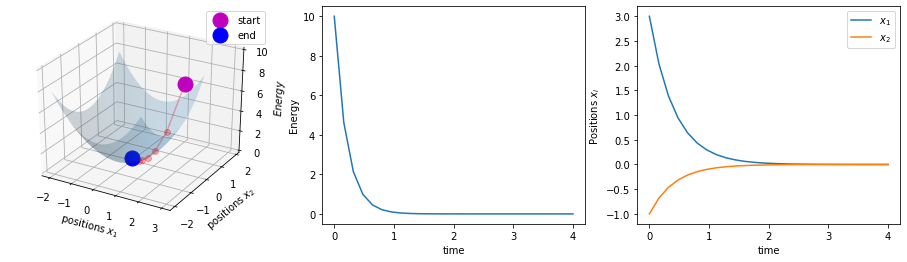

In [ ]:
o  = Vertex(torch.tensor([0.,0.],dtype=torch.float64))
v1 = Vertex(torch.tensor([3.,-1.],requires_grad=True,dtype=torch.float64))
r = o.dist(v1)
print(f'distance from origin (r):{r.item():.4f}')
# Define energy
k = 1.0
energy = lambda r: k*r**2
E = energy(r)
print(f'Energy=kr^2 :{E.item():.4f}')
# compute gradients
E.backward()
dEdx = v1.grad().detach()
dxdt = -dEdx
print(f't=0: dE/dx={dEdx.tolist()} --> dx/dt=-dE/dx={dxdt.tolist()}')
# Numerical integration
Dt = .16 # time step size
positions = [v1.x.tolist()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(25):
    v1.zero_grad_()
    r = o.dist(v1) # distance from origin
    E = energy(r)  # elastic energy
    Energies.append(E.item())
    E.backward()   # compute gradients
    dxdt = -v1.grad().data # dx/dt=-dE/dx
    if n%5==0:
        print(f't={Dt*n:.2f}:r={r.item():.2f}; x={v1}; E={E.item():.2f}; dx/dt=-dE/dx={dxdt.tolist()}')
    # Update vertex position
    with torch.no_grad():
        v1.x += dxdt*Dt
    positions.append(v1.x.tolist()); t.append(t[-1]+Dt)
Energies.append( energy(o.dist(v1)).item() )

# Display the results
positions = np.array(positions) # convert to a np array
fig = plt.figure(figsize=plt.figaspect(0.25))
# Energy as a function of position
ax = fig.add_subplot(1, 3, 1, projection='3d')
# Plot the Energy surface
Xmesh,Ymesh = np.meshgrid(np.arange(-2,2,.1),np.arange(-2,2,.1))
Zmesh = Xmesh**2+Ymesh**2
ax.plot_surface(Xmesh,Ymesh, Zmesh, alpha=0.2)
# Plot trajectory of the vertex E,x1,x2
ax.plot(positions[:,0],positions[:,1],Energies,'ro-',alpha=.3)
ax.plot(positions[:1,0],positions[:1,1],Energies[:1],'mo',ms=15,label='start')
ax.plot(positions[-1:,0],positions[-1:,1],Energies[-1:],'bo',ms=15,label='end')
ax.set_xlabel('positions $x_1$'); ax.set_ylabel('positions $x_2$'); ax.set_zlabel('$Energy$'); plt.legend();
# Energy as function of time
ax = fig.add_subplot(1, 3, 2); ax.plot(t,Energies); ax.set_xlabel('time'); ax.set_ylabel('Energy')
# 
ax = fig.add_subplot(1, 3, 3)
ax.plot(t,positions);plt.legend(['$x_1$','$x_2$']); ax.set_ylabel('Positions $x_i$'); ax.set_xlabel('time');
plt.show()

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted index.ipynb.
